In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import svd
import tensorflow_datasets as tfds
import time
import matrix_completion_functions as mc

## Test on real datasets

In [2]:
#stepsize_methods = ['dim', 'armijo', 'lipschitz', 'line']

stepsize_methods = ['line']

# Netflix Dataset

In [3]:
df = mc.load_netflix_data("combined_data_1.txt")

In [4]:
# Netflix data preprocessing

user_counts_nf = df['user_id'].value_counts()
movie_counts_nf = df['movie_id'].value_counts()

user_threshold_nf = user_counts_nf.quantile(0.99)
movie_threshold_nf = movie_counts_nf.quantile(0.95)

top_users_nf = user_counts_nf[user_counts_nf >= user_threshold_nf].index
top_movies_nf = movie_counts_nf[movie_counts_nf >= movie_threshold_nf].index

df_nf = df[df['user_id'].isin(top_users_nf) & df['movie_id'].isin(top_movies_nf)]

df_nf = df_nf[df_nf['date'].str.startswith('2005')].copy()
df_nf['date'] = pd.to_datetime(df_nf['date'])

movie_counts_nf = df_nf['movie_id'].value_counts()
valid_movies_nf = movie_counts_nf[movie_counts_nf >= 3].index
df_nf = df_nf[df_nf['movie_id'].isin(valid_movies_nf)]

df_nf = df_nf.sort_values(by=['movie_id', 'date'])
df_nf['rank'] = df_nf.groupby('movie_id')['date'].rank(method='first', ascending=False)

# Split: test = last, val = penultimate, train = rest
test_df_nf = df_nf[df_nf['rank'] == 1].copy()
val_df_nf = df_nf[df_nf['rank'] == 2].copy()
train_df_nf = df_nf[df_nf['rank'] > 2].copy()

# drop unnecessary columns
for d_nf in (train_df_nf, val_df_nf, test_df_nf):
    d_nf.drop(columns=['date', 'rank'], inplace=True)

# Create user and movie indices
all_users_nf = pd.concat([train_df_nf['user_id'], val_df_nf['user_id'], test_df_nf['user_id']]).unique()
all_movies_nf = pd.concat([train_df_nf['movie_id'], val_df_nf['movie_id'], test_df_nf['movie_id']]).unique()

user2idx_nf = {u: i for i, u in enumerate(sorted(all_users_nf))}
movie2idx_nf = {m: i for i, m in enumerate(sorted(all_movies_nf))}

num_users_nf = len(user2idx_nf)
num_movies_nf = len(movie2idx_nf)

# initialize full ratings matrix and masks
ratings_matrix_full_nf = np.zeros((num_users_nf, num_movies_nf))
mask_train_nf = np.zeros_like(ratings_matrix_full_nf)
mask_val_nf = np.zeros_like(ratings_matrix_full_nf)
mask_test_nf = np.zeros_like(ratings_matrix_full_nf)

# helper function to fill the ratings matrix and masks
def fill_matrix_nf(df_part_nf, mask_nf):
    for _, row_nf in df_part_nf.iterrows():
        u_nf, m_nf = user2idx_nf[row_nf['user_id']], movie2idx_nf[row_nf['movie_id']]
        ratings_matrix_full_nf[u_nf, m_nf] = row_nf['rating']
        mask_nf[u_nf, m_nf] = 1

fill_matrix_nf(train_df_nf, mask_train_nf)
fill_matrix_nf(val_df_nf, mask_val_nf)
fill_matrix_nf(test_df_nf, mask_test_nf)

print(f"Matrix shape: {ratings_matrix_full_nf.shape}")
print(f"Train ratings: {int(mask_train_nf.sum())}")
print(f"Validation ratings: {int(mask_val_nf.sum())}")
print(f"Test ratings: {int(mask_test_nf.sum())}")
print(f"Full density: {mc.calculate_density(ratings_matrix_full_nf):.4f}")

Matrix shape: (4695, 225)
Train ratings: 232510
Validation ratings: 225
Test ratings: 225
Full density: 0.2205


In [5]:
results_fw_nf = {}
results_pair_nf = {}
results_pg_nf = {}


mask_train_val_nf = mask_train_nf + mask_val_nf

for s in stepsize_methods:
    print(f"Running with stepsize: {s}")
    
    # Frank-Wolfe
    time_fw_start = time.time()
    X_fw, losses_fw, duality_gaps_fw = mc.FW(ratings_matrix_full_nf * mask_train_val_nf, 2600, 400, s, 1e-4, mask=mask_train_val_nf)
    time_fw_end = time.time()
    time_fw = time_fw_end - time_fw_start
    results_fw_nf[s] = {
        'X': X_fw,
        'losses': losses_fw,
        'duality_gaps': duality_gaps_fw,
        'time': time_fw
    }
    
    # Pairwise FW
    time_pair_start = time.time()
    X_pair, losses_pair, duality_gaps_pair = mc.pairwise_FW(ratings_matrix_full_nf * mask_train_val_nf, 3010, 400, s, 1e-4, mask=mask_train_val_nf)
    time_pair_end = time.time()
    time_pair = time_pair_end - time_pair_start
    results_pair_nf[s] = {
        'X': X_pair,
        'losses': losses_pair,
        'duality_gaps': duality_gaps_pair,
        'time': time_pair
    }
    
    # Projected Gradient
    time_pg_start = time.time()
    X_pg, losses_pg, variations_pg = mc.projected_gradient(ratings_matrix_full_nf * mask_train_val_nf, 4700, 400, s, 1e-4, mask=mask_train_val_nf)
    time_pg_end = time.time()
    time_pg = time_pg_end - time_pg_start
    results_pg_nf[s] = {
        'X': X_pg,
        'losses': losses_pg,
        'variations': variations_pg,
        'time': time_pg
        }

Running with stepsize: line


Projected Gradient Iterations:  52%|█████▏    | 208/400 [00:19<00:17, 10.74it/s]


In [6]:
# RMSE and rank for Frank-Wolfe
for s in stepsize_methods:
    X_fw = results_fw_nf[s]['X']
    rmse_fw = mc.compute_rmse(X_fw, mask_test_nf, ratings_matrix_full_nf)
    rank_fw = np.linalg.matrix_rank(X_fw)
    results_fw_nf[s]['rmse_test'] = rmse_fw
    results_fw_nf[s]['rank'] = rank_fw

# RMSE and rank for Pairwise FW
for s in stepsize_methods:
    X_pair = results_pair_nf[s]['X']
    rmse_pair = mc.compute_rmse(X_pair, mask_test_nf, ratings_matrix_full_nf)
    rank_pair = np.linalg.matrix_rank(X_pair)
    results_pair_nf[s]['rmse_test'] = rmse_pair
    results_pair_nf[s]['rank'] = rank_pair

# RMSE and rank for Projected Gradient
for s in stepsize_methods:
    X_pg = results_pg_nf[s]['X']
    rmse_pg = mc.compute_rmse(X_pg, mask_test_nf, ratings_matrix_full_nf)
    rank_pg = np.linalg.matrix_rank(X_pg)
    results_pg_nf[s]['rmse_test'] = rmse_pg
    results_pg_nf[s]['rank'] = rank_pg


In [7]:
# build a DataFrame from the results

df_fw_nf = mc.build_results_df(results_fw_nf, 'Frank-Wolfe')
df_pair_nf = mc.build_results_df(results_pair_nf, 'Pairwise FW')
df_pg_nf = mc.build_results_df(results_pg_nf, 'Projected Gradient')

df_results_nf = pd.concat([df_fw_nf, df_pair_nf, df_pg_nf], ignore_index=True)

df_results_nf = df_results_nf.sort_values(by=['method', 'stepsize']).reset_index(drop=True)

# Print the results DataFrame
print(df_results_nf.to_string(index=False))


            method stepsize  rmse_test  rank   time_sec
       Frank-Wolfe     line   1.263340    68  11.621727
       Pairwise FW     line   1.089430   188 101.972009
Projected Gradient     line   0.888737    96  19.379359


# Amazon Gift Cards Dataset

In [8]:
# Gift Cards data preprocessing
train_df_am = pd.read_csv("Gift_Cards_train.csv")
val_df_am = pd.read_csv("Gift_Cards_valid.csv")
test_df_am = pd.read_csv("Gift_Cards_test.csv")

train_df_am['user_idx'] = train_df_am['user_id'].astype('category').cat.codes
train_df_am['item_idx'] = train_df_am['parent_asin'].astype('category').cat.codes

user2idx_am = dict(zip(train_df_am['user_id'], train_df_am['user_idx']))
item2idx_am = dict(zip(train_df_am['parent_asin'], train_df_am['item_idx']))

num_users_am = len(user2idx_am)
num_items_am = len(item2idx_am)

ratings_matrix_full_am = np.zeros((num_users_am, num_items_am))
mask_train_am = np.zeros_like(ratings_matrix_full_am)
mask_val_am = np.zeros_like(ratings_matrix_full_am)
mask_test_am = np.zeros_like(ratings_matrix_full_am)

for _, row in train_df_am.iterrows():
    u, i = row['user_idx'], row['item_idx']
    ratings_matrix_full_am[u, i] = row['rating']
    mask_train_am[u, i] = 1

# filter and add validation and test data
def add_split_data(df_split, mask_target):
    df_filtered = df_split[
        df_split['user_id'].isin(user2idx_am) &
        df_split['parent_asin'].isin(item2idx_am)
    ].copy()
    df_filtered['user_idx'] = df_filtered['user_id'].map(user2idx_am)
    df_filtered['item_idx'] = df_filtered['parent_asin'].map(item2idx_am)

    count_added = 0
    for _, row in df_filtered.iterrows():
        u, i = int(row['user_idx']), int(row['item_idx'])
        if mask_train_am[u, i] == 0 and mask_val_am[u, i] == 0 and mask_test_am[u, i] == 0:
            ratings_matrix_full_am[u, i] = row['rating']
            mask_target[u, i] = 1
            count_added += 1
    return df_filtered, count_added

# add validation and test data
val_df_filtered_am, val_added_am = add_split_data(val_df_am, mask_val_am)
test_df_filtered_am, test_added_am = add_split_data(test_df_am, mask_test_am)

print(f"FULL matrix shape: {ratings_matrix_full_am.shape}, density: {mc.calculate_density(ratings_matrix_full_am):.4f}")
print(f"Train density: {np.count_nonzero(mask_train_am)/mask_train_am.size:.4f} - n={np.count_nonzero(mask_train_am)}")
print(f"Validation density: {np.count_nonzero(mask_val_am)/mask_val_am.size:.4f} - n={np.count_nonzero(mask_val_am)}")
print(f"Test density: {np.count_nonzero(mask_test_am)/mask_test_am.size:.4f} - n={np.count_nonzero(mask_test_am)}")

print(f"\nVal rows filtered: {len(val_df_filtered_am)}, actually added: {val_added_am}")
print(f"Test rows filtered: {len(test_df_filtered_am)}, actually added: {test_added_am}")

FULL matrix shape: (377, 129), density: 0.0499
Train density: 0.0344 - n=1675
Validation density: 0.0078 - n=377
Test density: 0.0078 - n=377

Val rows filtered: 377, actually added: 377
Test rows filtered: 377, actually added: 377


In [9]:
mask_train_am = mask_train_am.astype(float)
mask_val_am = mask_val_am.astype(float)
mask_test_am = mask_test_am.astype(float)
mask_train_val_am = mask_train_am + mask_val_am

In [10]:
u, s, vt = svd(ratings_matrix_full_am * mask_train_val_am, full_matrices=False)
print(sum(s).round())
rank_true_amazon = np.linalg.matrix_rank(ratings_matrix_full_am)
print(rank_true_amazon)

2127.0
129


In [11]:
results_fw_am = {}
results_pair_am = {}
results_pg_am = {}

for s in stepsize_methods:
    print(f"Running with stepsize: {s}")

    # Frank-Wolfe
    time_fw_start = time.time()
    X_fw, losses_fw, duality_gaps_fw = mc.FW(ratings_matrix_full_am * mask_train_val_am, 685, 400, s, 1e-4, mask=mask_train_val_am)
    time_fw_end = time.time()
    time_fw = time_fw_end - time_fw_start
    results_fw_am[s] = {
        'X': X_fw,
        'losses': losses_fw,
        'duality_gaps': duality_gaps_fw,
        'time': time_fw
    }

    # Pairwise FW
    time_pair_start = time.time()
    X_pair, losses_pair, duality_gaps_pair = mc.pairwise_FW(ratings_matrix_full_am * mask_train_val_am, 600, 400, s, 1e-4, mask=mask_train_val_am)
    time_pair_end = time.time()
    time_pair = time_pair_end - time_pair_start
    results_pair_am[s] = {
        'X': X_pair,
        'losses': losses_pair,
        'duality_gaps': duality_gaps_pair,
        'time': time_pair
    }

    # Projected Gradient
    time_pg_start = time.time()
    X_pg, losses_pg, variations_pg = mc.projected_gradient(ratings_matrix_full_am * mask_train_val_am, 880, 400, s, 1e-4, mask=mask_train_val_am, verbose = 1)
    time_pg_end = time.time()
    time_pg = time_pg_end - time_pg_start
    results_pg_am[s] = {
        'X': X_pg,
        'losses': losses_pg,
        'variations': variations_pg,
        'time': time_pg
    }

Running with stepsize: line


Projected Gradient Iterations: 100%|██████████| 400/400 [00:03<00:00, 124.69it/s]


In [12]:
for s in stepsize_methods:
    X_fw = results_fw_am[s]['X']
    rmse_fw = mc.compute_rmse(X_fw, mask_test_am, ratings_matrix_full_am)
    rank_fw = np.linalg.matrix_rank(X_fw)
    results_fw_am[s]['rmse_test'] = rmse_fw
    results_fw_am[s]['rank'] = rank_fw

for s in stepsize_methods:
    X_pair = results_pair_am[s]['X']
    rmse_pair = mc.compute_rmse(X_pair, mask_test_am, ratings_matrix_full_am)
    rank_pair = np.linalg.matrix_rank(X_pair)
    results_pair_am[s]['rmse_test'] = rmse_pair
    results_pair_am[s]['rank'] = rank_pair

for s in stepsize_methods:
    X_pg = results_pg_am[s]['X']
    rmse_pg = mc.compute_rmse(X_pg, mask_test_am, ratings_matrix_full_am)
    rank_pg = np.linalg.matrix_rank(X_pg)
    results_pg_am[s]['rmse_test'] = rmse_pg
    results_pg_am[s]['rank'] = rank_pg

In [13]:
df_fw_am = mc.build_results_df(results_fw_am, 'Frank-Wolfe')
df_pair_am = mc.build_results_df(results_pair_am, 'Pairwise FW')
df_pg_am = mc.build_results_df(results_pg_am, 'Projected Gradient')

df_results_am = pd.concat([df_fw_am, df_pair_am, df_pg_am], ignore_index=True)

df_results_am = df_results_am.sort_values(by=['method', 'stepsize']).reset_index(drop=True)

print(df_results_am.to_string(index=False))

            method stepsize  rmse_test  rank  time_sec
       Frank-Wolfe     line   1.536650     2  0.652991
       Pairwise FW     line   1.856735    87  4.161993
Projected Gradient     line   0.929426     4  3.210581


# MovieLens Dataset

In [14]:
# ---- Download and Prepare MovieLens 100k ----

print("Downloading MovieLens 100k dataset...")
data_ml, info_ml = tfds.load('movielens/100k-ratings', split='train', with_info=True, try_gcs=True) # 'train' in this case loads the whole dataset
df_ml = tfds.as_dataframe(data_ml)

# Build user-item rating matrix
rating_matrix_ml = df_ml.pivot_table(index='user_id', columns='movie_id', values='user_rating')

# Convert to numpy array, fill NaNs with 0
M_true_ml = rating_matrix_ml.values
mask_ml = ~np.isnan(M_true_ml)
M_true_ml = np.nan_to_num(M_true_ml, nan=0.0)

train_mask_ml, validation_mask_ml, test_mask_ml = mc.split_data(M_true_ml, mask_ml.astype(bool), 0.2)

M_train_ml = mc.masking(M_true_ml, train_mask_ml)
M_val_ml = mc.masking(M_true_ml, validation_mask_ml)
M_test_ml = mc.masking(M_true_ml, test_mask_ml)

train_val_mask_ml = train_mask_ml + validation_mask_ml
M_train_val_ml = mc.masking(M_true_ml, train_val_mask_ml)

2025-07-10 16:10:03.017166: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-10 16:10:11.536732: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
print(f"Matrix shape: {M_true_ml.shape}")
print(f"Train ratings: {int(train_mask_ml.sum())}")
print(f"Validation ratings: {int(validation_mask_ml.sum())}")
print(f"Test ratings: {int(test_mask_ml.sum())}")
print(f"Full density: {mc.calculate_density(M_true_ml):.4f}")

Matrix shape: (943, 1682)
Train ratings: 72000
Validation ratings: 18000
Test ratings: 10000
Full density: 0.0630


In [16]:
results_fw_ml = {}
results_pair_ml = {}
results_pg_ml = {}

for s in stepsize_methods:
    print(f"Running with stepsize: {s}")

    # Frank-Wolfe
    time_fw_start = time.time()
    X_fw, losses_fw, duality_gaps_fw = mc.FW(M_train_val_ml * train_val_mask_ml, 6000, 400, s, 1e-4, mask=train_val_mask_ml)
    time_fw_end = time.time()
    time_fw = time_fw_end - time_fw_start
    results_fw_ml[s] = {
        'X': X_fw,
        'losses': losses_fw,
        'duality_gaps': duality_gaps_fw,
        'time': time_fw
    }

    # Pairwise FW
    time_pair_start = time.time()
    X_pair, losses_pair, duality_gaps_pair = mc.pairwise_FW(M_train_val_ml * train_val_mask_ml, 5000, 400, s, 1e-4, mask=train_val_mask_ml)
    time_pair_end = time.time()
    time_pair = time_pair_end - time_pair_start
    results_pair_ml[s] = {
        'X': X_pair,
        'losses': losses_pair,
        'duality_gaps': duality_gaps_pair,
        'time': time_pair
    }

    # Projected Gradient
    time_pg_start = time.time()
    X_pg, losses_pg, variations_pg = mc.projected_gradient(M_train_val_ml * train_val_mask_ml, 5000, 400, s, 1e-4, mask=train_val_mask_ml)
    time_pg_end = time.time()
    time_pg = time_pg_end - time_pg_start
    results_pg_ml[s] = {
        'X': X_pg,
        'losses': losses_pg,
        'variations': variations_pg,
        'time': time_pg
    }

Running with stepsize: line


Projected Gradient Iterations: 100%|██████████| 400/400 [04:20<00:00,  1.54it/s]


In [17]:
# time printing
for s in stepsize_methods:
    print(f"Stepsize: {s}")
    print(f"Time FW: {results_fw_ml[s]['time']}")
    print(f"Time Pairwise FW: {results_pair_ml[s]['time']}")
    print(f"Time PG: {results_pg_ml[s]['time']}")

Stepsize: line
Time FW: 47.662179946899414
Time Pairwise FW: 2760.0500497817993
Time PG: 260.4027359485626


In [18]:
for s in stepsize_methods:
    X_fw = results_fw_ml[s]['X']
    rmse_fw = mc.compute_rmse(X_fw, test_mask_ml, M_true_ml)
    rank_fw = np.linalg.matrix_rank(X_fw)
    results_fw_ml[s]['rmse_test'] = rmse_fw
    results_fw_ml[s]['rank'] = rank_fw

for s in stepsize_methods:
    X_pair = results_pair_ml[s]['X']
    rmse_pair = mc.compute_rmse(X_pair, test_mask_ml, M_true_ml)
    rank_pair = np.linalg.matrix_rank(X_pair)
    results_pair_ml[s]['rmse_test'] = rmse_pair
    results_pair_ml[s]['rank'] = rank_pair

for s in stepsize_methods:
    X_pg = results_pg_ml[s]['X']
    rmse_pg = mc.compute_rmse(X_pg, test_mask_ml, M_true_ml)
    rank_pg = np.linalg.matrix_rank(X_pg)
    results_pg_ml[s]['rmse_test'] = rmse_pg
    results_pg_ml[s]['rank'] = rank_pg

In [19]:
df_fw_ml = mc.build_results_df(results_fw_ml, 'Frank-Wolfe')
df_pair_ml = mc.build_results_df(results_pair_ml, 'Pairwise FW')
df_pg_ml = mc.build_results_df(results_pg_ml, 'Projected Gradient')

df_results_ml = pd.concat([df_fw_ml, df_pair_ml, df_pg_ml], ignore_index=True)

df_results_ml = df_results_ml.sort_values(by=['method', 'stepsize']).reset_index(drop=True)

print(df_results_ml.to_string(index=False))

            method stepsize  rmse_test  rank    time_sec
       Frank-Wolfe     line   0.980184   401   47.662180
       Pairwise FW     line   0.980019   379 2760.050050
Projected Gradient     line   0.951537   115  260.402736


# PLOTS

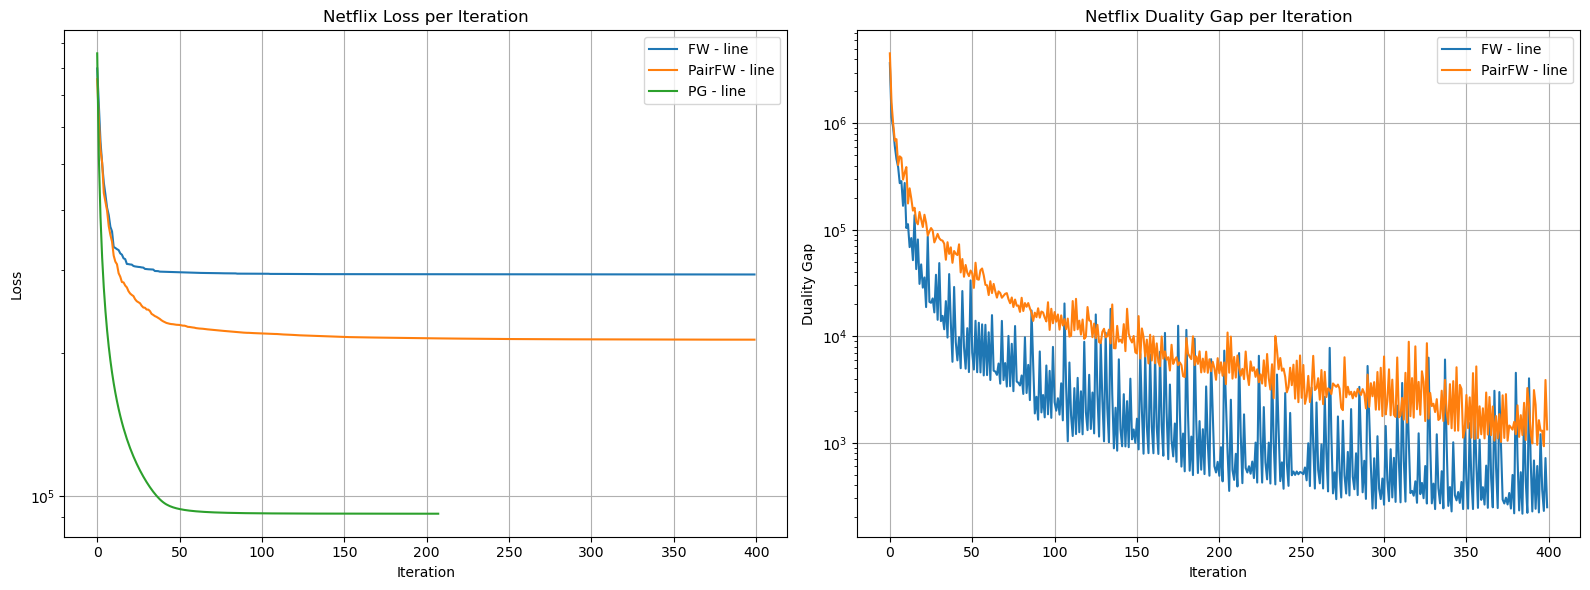

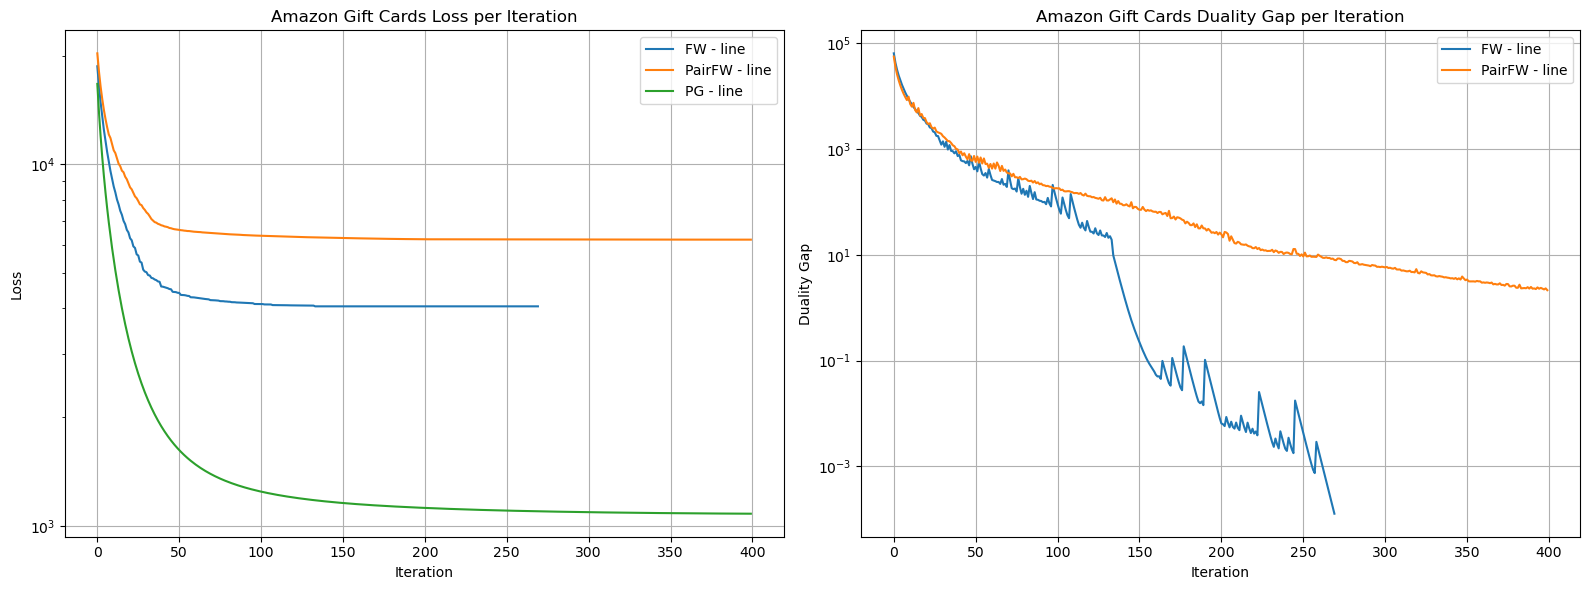

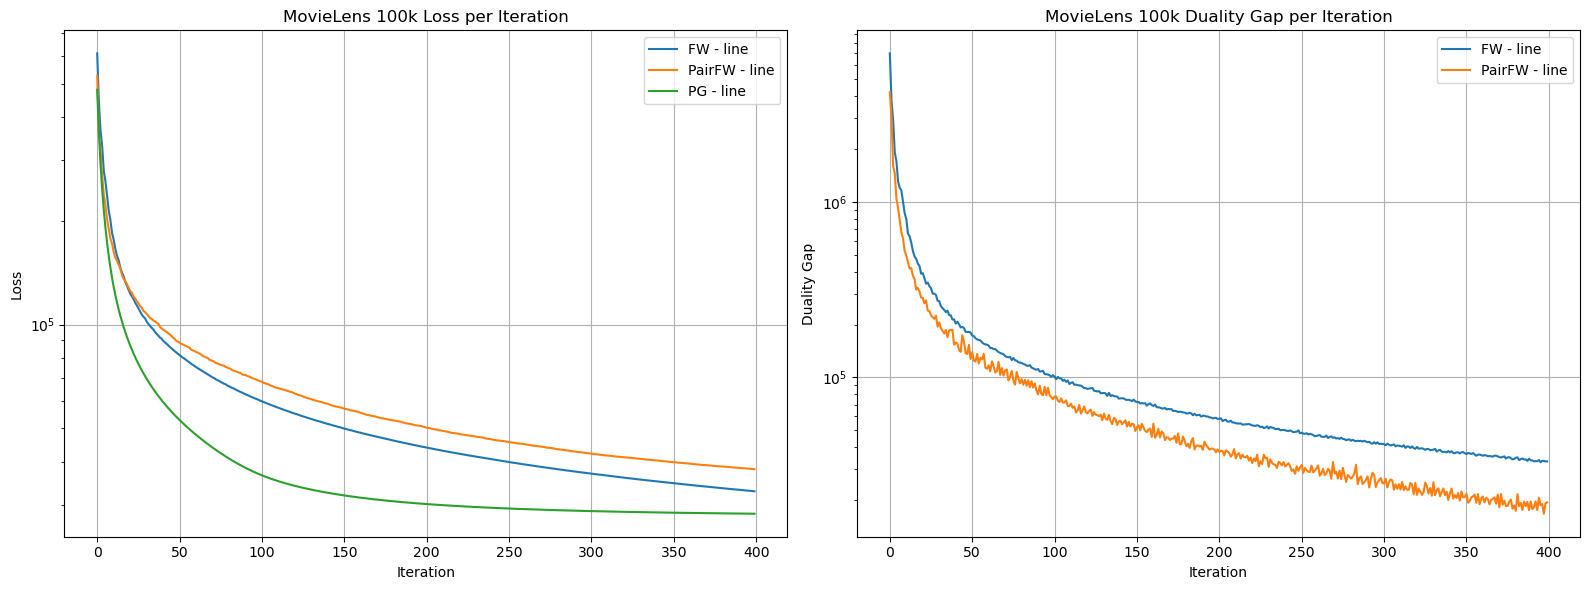

In [20]:
mc.plot_all_algorithms(
    results_fw_nf, results_pair_nf, results_pg_nf,
    log_scale=True, title_prefix="Netflix"
)

mc.plot_all_algorithms(
    results_fw_am, results_pair_am, results_pg_am,
    log_scale=True, title_prefix="Amazon Gift Cards"
)

mc.plot_all_algorithms(
    results_fw_ml, results_pair_ml, results_pg_ml,
    log_scale=True, title_prefix="MovieLens 100k"
) 